### Processing the data 

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score

import pymc3 as pm

In [22]:
dataset_link = "https://raw.githubusercontent.com/rashida048/Datasets/master/home_data.csv"

# import the dataset
df = pd.read_csv(dataset_link)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [23]:
# drop id and date 
df_ = df.drop(["id", "date"], axis=1)

# split train and test sets
train_set, test_set = train_test_split(df_, test_size=0.2, random_state=42)

#Create a copy of this training set to play with.
housing = train_set.copy()

# Remove MEDV from the housing dataframe
housing = train_set.drop("price", axis = 1)

# Create a 'labels' dataframe to store the median values
housing_labels = train_set["price"].copy()

In [24]:
#It is good practice to set up a pipeline for transformations to our data. In this case we are only using one, a scaler
#which brings all features on to the similar scale, so they can be directly compared, but we can easily add more if required
pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

#We now apply this pipeline to the housing dataset to create the set we can train our models on
housing_tr = pipeline.fit_transform(housing)

### Train model

#### 1. Linear Regression

In [25]:
#Firstly we will train a basic Multi-Variate Linear regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_tr, housing_labels)

LinearRegression()

In [26]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = pipeline.transform(some_data)

In [27]:
housing_predictions = lin_reg.predict(housing_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

198272.24322458316

In [28]:
r2_score(housing_labels, housing_predictions, multioutput='variance_weighted')

0.699102184301204

#### Random Forest Regressor

In [29]:
rfregr = RandomForestRegressor(max_depth=10, random_state=0)
rfregr.fit(housing_tr, housing_labels)

housing_predictions = rfregr.predict(housing_tr)
rf_mse = mean_squared_error(housing_labels, housing_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

93851.30284876762

In [30]:
r2_score(housing_labels, housing_predictions, multioutput='variance_weighted')

0.9325820090327684

#### Bayesian Regression

In [31]:
r2_score(housing_labels, housing_predictions, multioutput='variance_weighted')

0.9325820090327684

#### Truncate data for Bayesian

In [32]:
def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])

[Text(0.5, 1.0, 'Truncated data')]

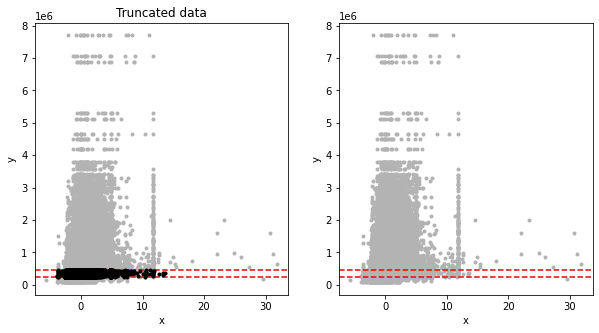

In [33]:
x = housing_tr
y = housing_labels

bounds = [250000, 450000]
xt, yt = truncate_y(x, y, bounds)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax in axes:
    ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
    ax.axhline(bounds[0], c="r", ls="--")
    ax.axhline(bounds[1], c="r", ls="--")
    ax.set(xlabel="x", ylabel="y")

axes[0].plot(xt, yt, ".", c=[0, 0, 0])
axes[0].set(title="Truncated data")

# axes[1].plot(xt, yt, ".", c=[0, 0, 0])

In [34]:
# truncate the housing dataset to illustrate the point

housing_truncated = housing.iloc[1:10]
# housing_truncated
# housing_labels[1:10]
# housing_truncated
housing_truncated['bathrooms'].values

array([1.  , 1.  , 2.25, 2.5 , 1.75, 2.75, 2.25, 1.75, 2.5 ])

In [35]:
with pm.Model() as independent_regression_model:
    # data
    x1 = pm.Data('x1',housing_truncated['sqft_living'].values)
    x2 = pm.Data('x2',housing_truncated['grade'].values)
    x3 = pm.Data('x3',housing_truncated['sqft_above'].values)
    x4 = pm.Data('x4',housing_truncated['sqft_living15'].values)
    x5 = pm.Data('x5',housing_truncated['bathrooms'].values)
    y1 = pm.Data('y1',housing_labels[1:10].values)

    # prior
    alpha = pm.Normal('beta_0',0,10)
    beta_1 = pm.Normal('beta_1',0,10)
    beta_2 = pm.Normal('beta_2',0,10)
    beta_3 = pm.Normal('beta_3',0,10)
    beta_4 = pm.Normal('beta_4',0,10)
    beta_5 = pm.Normal('beta_5',0,10)
    sigma = pm.Exponential('error',lam=1)

    mu = alpha + beta_1*x1 + beta_2*x2 + beta_3*x3 + beta_4*x4 + beta_5*x5
    y_hat = pm.Normal('y_hat',mu,sigma,observed=y1)

    trace_independent_regression = pm.sample(draws=100,tune=100)

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\tools\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\tools\Anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [error, beta_5, beta_4, beta_3, beta_2, beta_1, beta_0]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 44 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


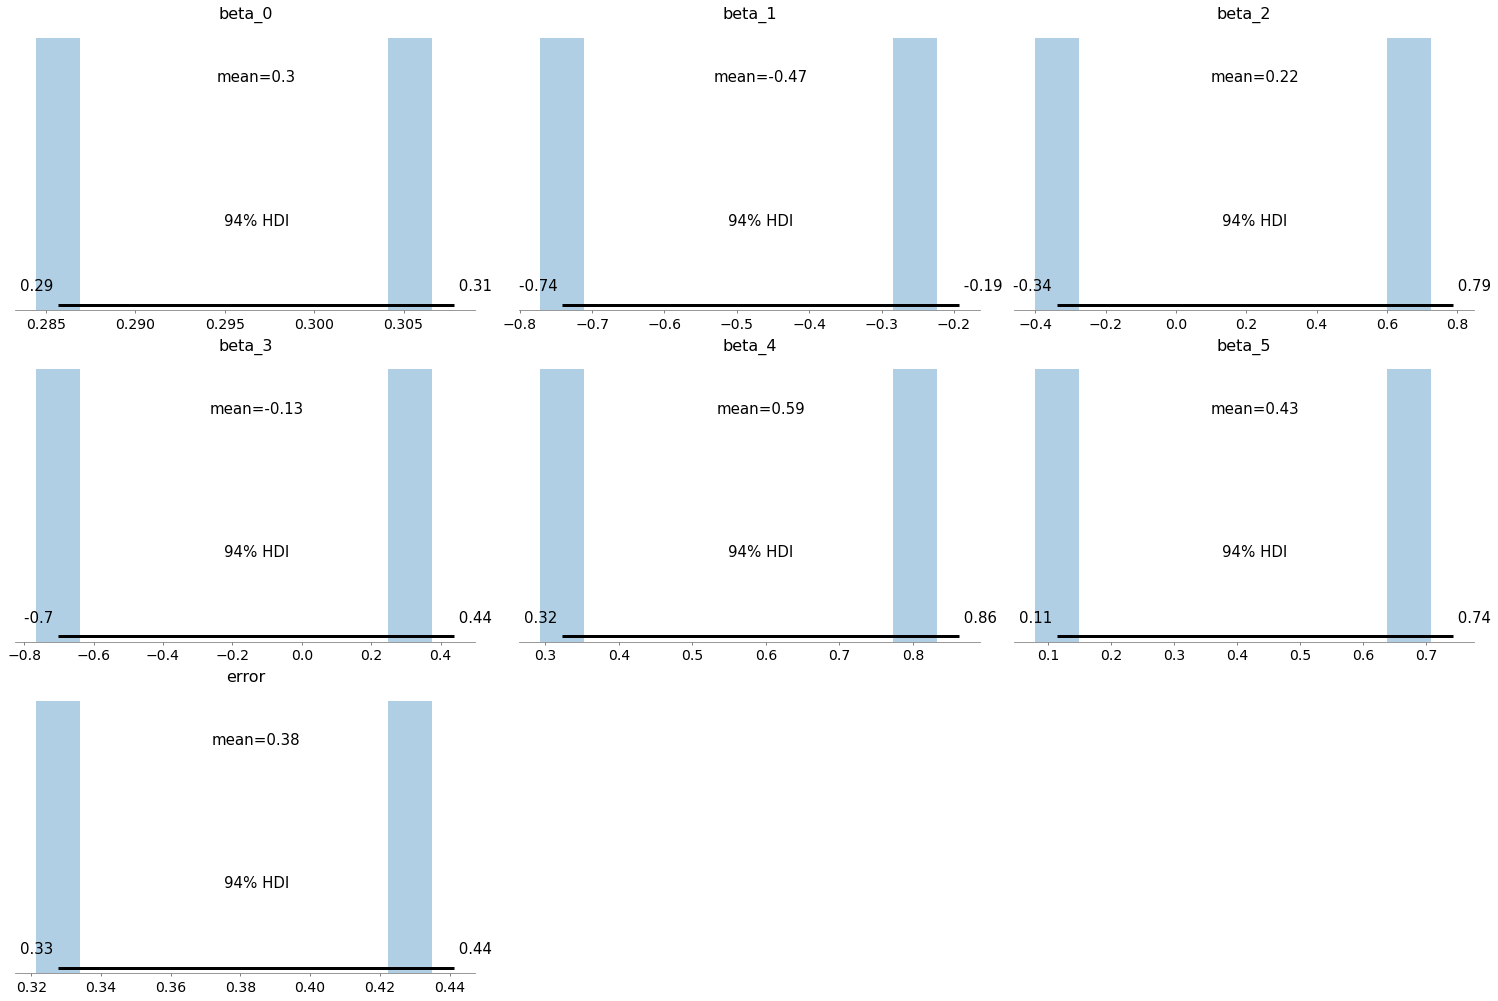

In [41]:
import arviz as az

az.plot_posterior(
    trace_independent_regression, kind="hist"
);

In [44]:
samples = pm.sample_posterior_predictive(trace_independent_regression, samples=1000, model=independent_regression_model)

In [74]:
housing_label_array = housing_labels[1:10].to_numpy()

In [76]:
r_2 = []
for i in range(1000):
    y_pred = samples['y_hat'][i]
    r_2.append(r2_score(housing_label_array, y_pred, multioutput='variance_weighted'))
    
print("Mean R-squared for samples of size 1000: ", sum(r_2)/len(r_2))

Mean R-squared for samples of size 1000:  -5.8343637519878735
